In [1]:
%matplotlib inline

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from PIL import Image
import scipy.ndimage as ndimage
from scipy.stats import norm
from scipy.stats import multivariate_normal
from numpy.linalg import LinAlgError
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering
from sklearn.neighbors import NearestNeighbors
from scipy.optimize import differential_evolution
from scipy.optimize import basinhopping

In [3]:
# Read labels and sample submission
labels = pd.read_csv('data/stage1_train_labels.csv')
sample_submit = pd.read_csv('data/stage1_sample_submission.csv')

labels.head()

,ImageId,EncodedPixels
0,00071198d059ba7f5914a526d124d28e6d010c92466da2...,6908 1 7161 8 7417 8 7672 9 7928 9 8184 9 8440...
1,00071198d059ba7f5914a526d124d28e6d010c92466da2...,36269 7 36523 11 36778 13 37033 15 37288 17 37...
2,00071198d059ba7f5914a526d124d28e6d010c92466da2...,19919 6 20174 8 20429 10 20685 11 20941 12 211...
3,00071198d059ba7f5914a526d124d28e6d010c92466da2...,18671 6 18926 8 19181 9 19436 10 19691 11 1994...
4,00071198d059ba7f5914a526d124d28e6d010c92466da2...,40158 3 40413 5 40669 5 40925 5 41182 3


In [4]:
# Functions to read images
cases = os.listdir('data/stage1_train')

def get_im(i, cases=cases):
    """
    :param i: int, image index
    :return: Image instance
    """
    im = Image.open('data/stage1_train/' + cases[i] + '/images/' + cases[i] + '.png')
    return im

def get_imdata(i):
    """
    :param i: int, image index
    :return: 2D array with the image in grayscale
    """
    im = get_im(i).convert('L')
    return np.array(im.getdata()).reshape((im.size[1], im.size[0]))

def get_mask(i):
    """
    :param i: int, image index
    :return: 2D array with mask (0s and 1s)
    """
    # Calculate mask
    imdata = get_imdata(i)

    # Change integers to floats in the range 0-1
    imdata = imdata + np.abs(imdata.min())
    imdata = imdata/imdata.max()

    # Invert if the background is bright
    if imdata.mean() > 0.5:
        imdata = np.abs(1 - imdata)
    
    # Apply binary mask (only 0 and 1 allowed)
    mask = np.where(imdata > imdata.min() + 1.5 * imdata.std(), 1., 0.)
        
    return mask

def get_iminfo():
    """
    Returns info about all images. Currently: width, height
    """
    df = pd.DataFrame()
    i = 0
    for c in cases:
        im = get_im(i).convert('L')
        df = df.append(pd.Series({
            'case': c,
            'width': im.size[0],
            'height': im.size[1]
        }), ignore_index=True)
        i += 1
    return df

def get_case_index(case):
    """
    :param case: string wi
    """
    for c, i in zip(cases, np.arange(len(cases))):
        if c == worst:
            return i

## Trying to detect nuclei by sequential clusterring

In [5]:
# Plot comparison
def plot_comparison(i, circs=None, circs2=None, mask=None):
    if mask is None:
        mask = get_mask(i)
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5), dpi=80);
    ax[0].imshow(get_imdata(i));
    ax[0].set_title('Original');
    ax[1].imshow(mask);
    ax[1].set_title('Filtered');

    if circs is not None:
        for row in circs.index:
            x = circs.loc[row, 'xc']
            y = circs.loc[row, 'yc']
            r = circs.loc[row, 'r']
            circle = plt.Circle((x, y), r, color='r', fill=False)
            ax[1].add_artist(circle)
    if circs2 is not None:
        for row in circs2.index:
            x = circs2.loc[row, 'xc']
            y = circs2.loc[row, 'yc']
            r = circs2.loc[row, 'r']
            circle = plt.Circle((x, y), r, color='g', fill=False)
            ax[1].add_artist(circle)
    return ax

### First stage clustering: detects groups of nuclei and evaluate number of nuclei in each group

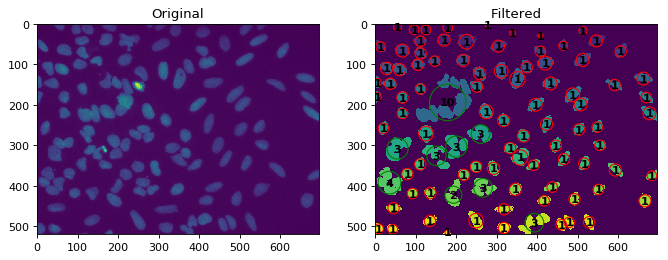

In [182]:
imix = 40
ymax = get_im(imix).size[0]
xmax = get_im(imix).size[1]

r = 7
x = random.randint(0 + r, xmax - r)
y = random.randint(0 + r, ymax - r)

mask = get_mask(imix)
pixels = np.argwhere(mask) # Pixel indices

# Clusters
db = DBSCAN(eps=5, min_samples=50).fit(pixels)
labels = db.labels_ + 1
unique_labels = set(labels)
for p, l in zip(pixels, labels):
    mask[p[0], p[1]] = l

labframe = pd.DataFrame(data=pixels, columns=['y', 'x'])
labframe['label'] = labels

# Drop noisy pixels
labframe = labframe.drop(labframe.loc[labframe['label'] == 0.].index)

# Calculate centers
labframe['yc'] = np.nan
labframe['xc'] = np.nan
for l in unique_labels:
    yc = labframe.loc[labframe['label'] == l, 'y'].mean()
    xc = labframe.loc[labframe['label'] == l, 'x'].mean()
    labframe.loc[labframe['label'] == l, 'yc'] =  yc
    labframe.loc[labframe['label'] == l, 'xc'] =  xc

# Summary dataframe
centers = labframe.groupby('label').mean().drop(['x', 'y'], axis=1)
summary = centers.copy()
summary['size'] = labframe.groupby('label').count()['x'].values
summary['r'] = (summary['size'] / np.pi) ** 0.5  # A = pi*r^2 => r = (A / pi) ** 0.5
summary = summary.round()

# Add categories
summary['ctg'] = None
sml_lim = max([summary['size'].median() - 1.0 * summary['size'].std(), 30])
lrg_lim = summary['size'].median() + 1.0 * summary['size'].std()
summary.loc[summary['size'] <= sml_lim, 'ctg'] = 'small'
summary.loc[(sml_lim < summary['size']) & (summary['size'] < lrg_lim), 'ctg'] = 'normal'
summary.loc[summary['size'] > lrg_lim, 'ctg'] = 'large'

# Guess how many nuclei hide in the large and small clusters
median_size = summary.loc[summary['ctg'] == 'normal']['size'].mean()
summary['n'] = 1
summary.loc[summary['ctg'] == 'large', 'n'] = (summary['size'] / median_size).round().astype(int)
summary.loc[summary['ctg'] == 'small', 'n'] = (summary['size'] / median_size).round().astype(int)

# Remove categories
summary = summary.drop('ctg', axis=1)

# Plot comparison
ax = plot_comparison(imix, summary.loc[summary['n'] == 1],
                     summary.loc[summary['n'] > 1], mask=mask);
for l in summary.index:
    if summary.loc[l, 'n'] >= 1.:
        n = str(int(summary.loc[l, 'n']))
        x = summary.loc[l, 'xc']
        y = summary.loc[l, 'yc']
        ax[1].text(x, y, n, color='k', ha='center', va='center', weight=1000)

### Second stage clustering: split clusters of nuclei into separate nuclei

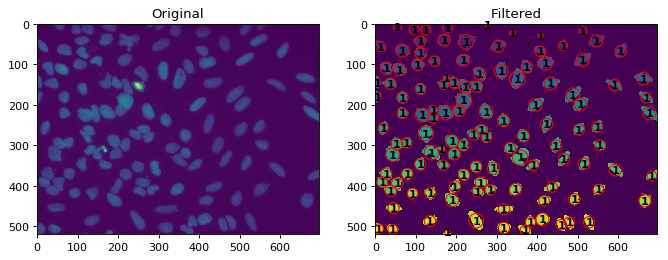

In [183]:
# Copy labframe
labframe2 = labframe.copy()

# Remove pixels of small clusters
less_than_1 = summary.loc[summary['n'] < 1].index
for l in less_than_1:
    labframe2 = labframe2.loc[labframe2['label'] != l]

# Split large clusters into smaller
more_than_1 = summary.loc[summary['n'] > 1].index.copy()
for l in more_than_1:
    # Get sample of pixels
    pixels = labframe2.loc[labframe2['label'] == l][['y', 'x']].values
    # Cluster
    n_clusters = summary.loc[l, 'n'].astype(int)
    sc = SpectralClustering(n_clusters=n_clusters).fit(pixels)
    # Rename labels to avoid overlapping categories
    sc_labels = sc.labels_ + labframe2['label'].max() + 1
    # Calculate new centers
    centers = pd.DataFrame(index=pd.Index(sc_labels, name='label'),
                           data=pixels, columns=['yc', 'xc'])
    centers = centers.groupby('label').mean()
    # Add to labframe
    labframe2 = labframe2.append(pd.DataFrame(
        data={
            'y': pixels[:,0],
            'x': pixels[:,1],
            'label': sc_labels,
            'yc': centers.loc[sc_labels]['yc'].values,
            'xc': centers.loc[sc_labels]['xc'].values
    }))
    # Remove previous label from labframe
    labframe2 = labframe2.loc[labframe2['label'] != l]
    
# Regenerate summary
centers = labframe2.groupby('label').mean().drop(['x', 'y'], axis=1)
summary2 = centers.copy()
summary2['size'] = labframe2.groupby('label').count()['x'].values
summary2['r'] = (summary2['size'] / np.pi) ** 0.5
summary2['n'] = 1
summary2 = summary2.round()

# Comparison
ax = plot_comparison(imix, summary2, mask=mask);
for l in summary2.index:
    n = str(int(summary2.loc[l, 'n']))
    x = summary2.loc[l, 'xc']
    y = summary2.loc[l, 'yc']
    ax[1].text(x, y, n, color='k', ha='center', va='center', weight=1000)

In [1]:
# Examples of difficult cases
# worst = '259b35151d4a7a5ffdd7ab7f171b142db8cfe40beeee67277fac6adca4d042c4'
# im = Image.open('data/stage1_test/{}/images/{}.png'.format(worst, worst))
# im